# Lab - Texture Analysis

## Part A

### Objective

The goal of this part is to segment the following photo into 3 segments: 
1. a segment for clothes with a jeans texture
2. a segment for clothes with a cotton texture
3. a segment for the background

<img src='test.jpg' width=100px heigth=300px></img>

In [16]:
# All the imports you will need in the whole lab
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import os
import numpy as np

## Section 1

In this section, you will extract features from image samples of the jeans and cotton texture using GLCM, then we will plot our feature space to see if our features are able to differentiate between the textures of jeans, cotton, and background. 

### TODO Implement get_glcm_features

You will need the following two functions:

greycomatrix, doc link -> https://scikit-image.org/docs/dev/api/skimage.feature.html#greycomatrix <br>
greycoprops, doc link -> https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops

In [3]:
def get_glcm_features(gray_scale_img):
    """
    Given a grayscale image with graylevels from 0 - 255, this function returns the contrast
    and the homogeneity features of the image with the help of GLCM
    """
    # Tip: Make sure you understand the input-output of everything you write, 
    # not doing that results in bugs that make you believe the lab is long
    glcm = graycomatrix(gray_scale_img, [1], [0, np.pi/2, np.pi, 3*np.pi/2])
    homogeneity = graycoprops(glcm, 'homogeneity')
    contrast = graycoprops(glcm, 'contrast')
    return contrast, homogeneity

gray_scale_image = (rgb2gray(io.imread('imgs_patches/jeans1.jpg')) * 255).astype(np.uint8)
contrast,homogeneity = get_glcm_features(gray_scale_image)

The following part will extract the contrast and homogeneity of samples of jeans and cotton in the folder "imgs_patches" using your function. So, for each sample image, we will have a point in a 2D feature space. Then, it will plot this feature space.

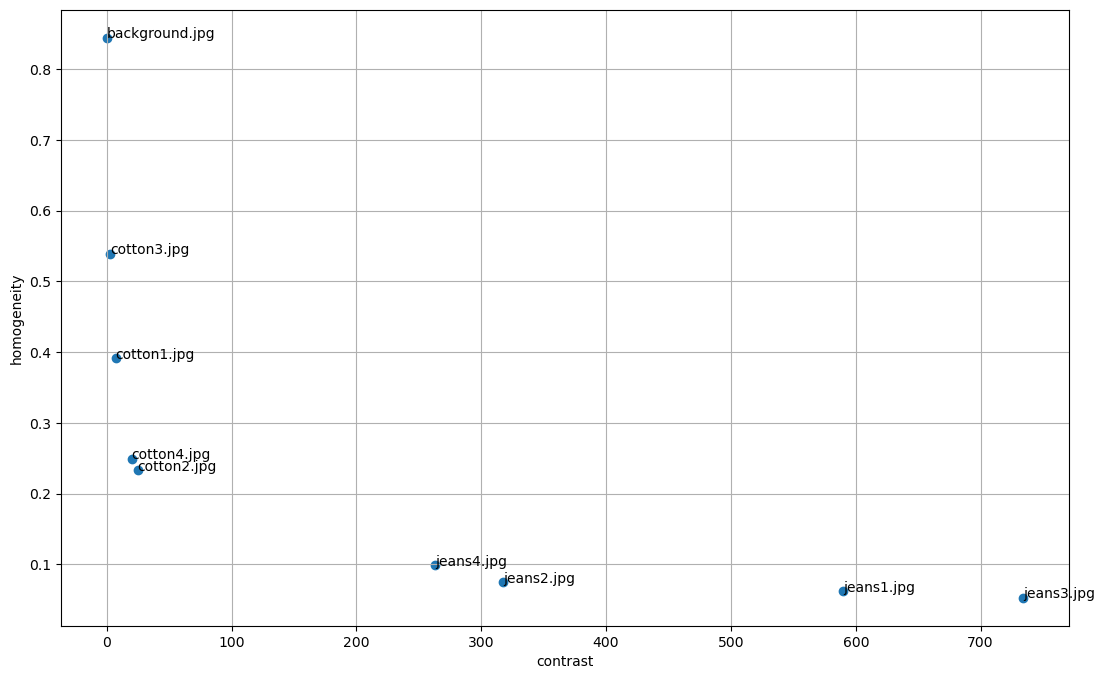

In [4]:
# You don't need to understand how this function works
def get_fname_images_tuple(directory):
    fnames = os.listdir(directory)
    to_return = []
    for fn in fnames:
        if fn[-3:] == 'jpg':
            path = os.path.join(directory, fn)
            gray_scale_image = (rgb2gray(io.imread(path)) * 255).astype(np.uint8)
            to_return.append((fn, gray_scale_image))
        else:
            print('This file has been skipped', fn)
    return to_return

# You don't need to understand how this function works
def plot_2d_features_with_names(names_fts_list, xlabel, ylabel):
    x = [np.average(names_fts[1][0][0]) for names_fts in names_fts_list]
    y = [np.average(names_fts[1][1][0]) for names_fts in names_fts_list]
    txts = [names_fts[0] for names_fts in names_fts_list]
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)

    for i, txt in enumerate(txts):
        ax.annotate(txt, (x[i], y[i]))
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig = plt.gcf()
    fig.set_size_inches(13, 8)
    
    
fn_img_list = get_fname_images_tuple(r'imgs_patches')

fn_ft_list = []
for fn, img in fn_img_list:
    fn_ft_list.append((fn, get_glcm_features(img)))

plot_2d_features_with_names(fn_ft_list, 'contrast', 'homogeneity')

## Section 2

You should have noticed that the previous section showed us that we can differentiate between jeans, cotton, & background patches using contrast and homogeneity. So, in this section, we will classify an unknown patch into one of those categories using a simple rule-based classifier. This will make us able to segment an image.

In [5]:
# TODO implement this function

def classify_patch(contrast, homogeneity):
    """
    Given the contrast and homogeneity values of a certain image patch, this function 
    will return the class of the patch, i.e either 'jeans', 'cotton', or 'background'
    """
    # Hint: We can decide whether the patch is background or not by simply checking 'if' the homogeneity is greater than a certain float value
    if np.average(homogeneity) > 0.7:
        return 'background'
    elif np.average(homogeneity) > 0.2 and np.average(contrast) < 100:
        return 'cotton'
    return 'jeans'

### TODO Complete todos in segment_img

This function is given an RGB image, and returns the segmented image coloring jeans patches in green, cotton patches in red, and the background in blue. Your final output should look like the following image:

<img src='target_output.jpg' width=100px heigth=300px></img>

In [6]:
def segment_img(image):
    img = image.copy()
    patch_height = patch_width = 50
    
    # TODO complete the following skeleton
    
    # loop on the image patch by patch
    for i in range(0, img.shape[0] // patch_height):
        for j in range(0, img.shape[1] // patch_width):
            rStart = i*patch_height
            cStart = j*patch_width
            
            patch = img[rStart:rStart+patch_height, cStart:cStart+patch_width]
            
            patch_grayscale = (rgb2gray(patch) * 255).astype(np.uint8)
            
            contrast, homogeneity = get_glcm_features(patch_grayscale)
            classification = classify_patch(contrast, homogeneity)
            
            if classification == 'cotton':
                patch[:,:, 0] = 255
            elif classification == 'jeans':
                patch[:,:, 1] = 255
            else:
                patch[:,:,2] = 255
                
    return img

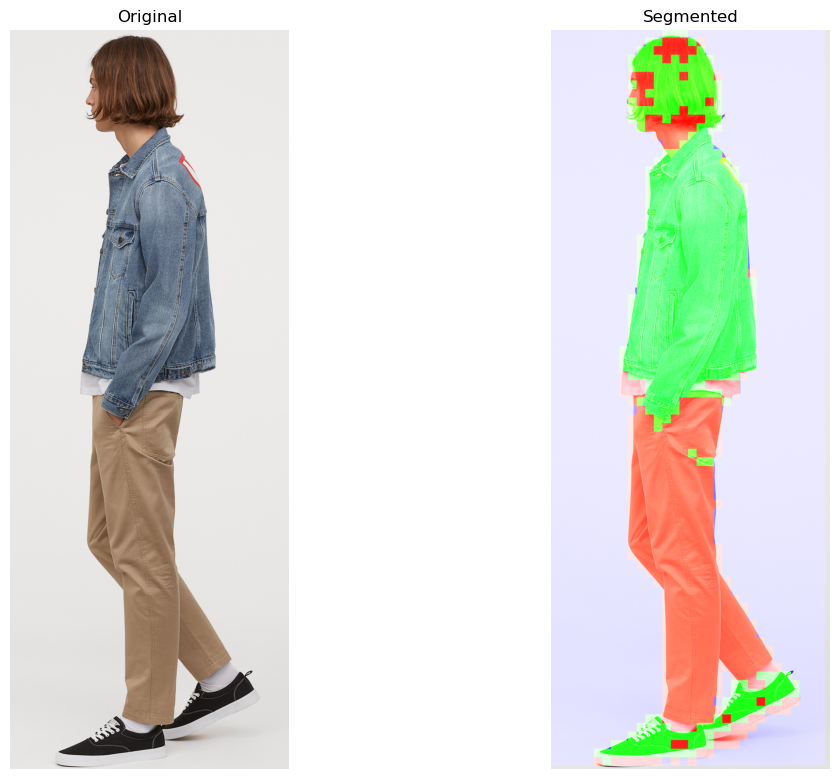

Cotton: Red
Jeans: Green
Else: Blue


In [17]:
# Testing your work
image = io.imread('test.jpg')
originaImage = image.copy()
segmented_image = segment_img(image)
show_images([originaImage, segmented_image], ['Original', 'Segmented'])
print('Cotton: Red')
print('Jeans: Green')
print('Else: Blue')

## Part B

You are required to implement your own function that computes the LBP histogram of a grayscale image (return to lecture slides for reference attached in this lab folder).

#### Note: you are allowed to ignore image border pixels.

In [8]:
def get_lbp_hist(grayscale_img):
    
    LBP_img = np.zeros((grayscale_img.shape[0]-2, grayscale_img.shape[1]-2))
    for i in range(1, grayscale_img.shape[0]-1):
        for j in range(1, grayscale_img.shape[1]-1):
            pixel = grayscale_img[i,j]
            LBP_img[i-1,j-1] = (2**7)*int(grayscale_img[i-1,j-1] > pixel) + (2**6)*int(grayscale_img[i-1,j] > pixel) + (2**5)*int(grayscale_img[i-1,j+1] > pixel) + (2**4)*int(grayscale_img[i,j+1] > pixel) + (2**3)*int(grayscale_img[i+1,j+1] > pixel) + (2**2)*int(grayscale_img[i+1,j] > pixel) + (2**1)*int(grayscale_img[i+1,j-1] > pixel) + (2**0)*int(grayscale_img[i,j-1] > pixel)
    
    hist,bins = np.histogram(LBP_img, bins=256)
    return hist

'ignore function output'

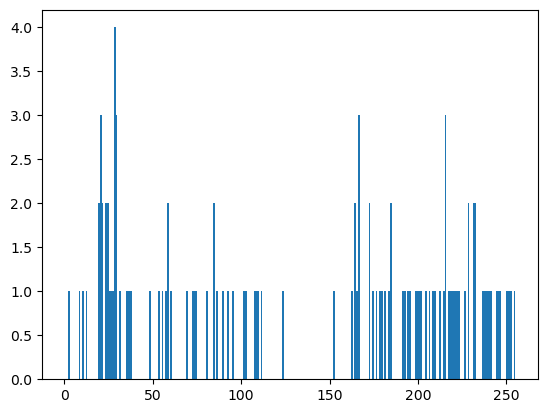

In [9]:
# Testing your work, we will compare your histogram with that of ours
# There should be a noticable difference between the histograms of jeans and cotton
img = rgb2gray(io.imread(r'imgs_patches/jeans1.jpg'))
hist = get_lbp_hist(img)
plt.hist(hist, bins=range((2 ** 8)))
'ignore function output'

'ignore function output'

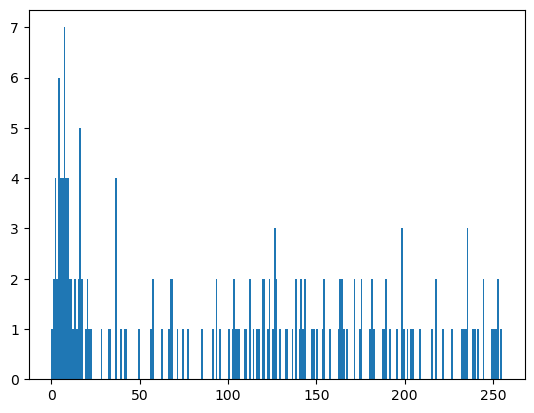

In [10]:
# Testing your work, we will compare your histogram with that of ours
# There should be a noticable difference between the histograms of jeans and cotton
img = rgb2gray(io.imread(r'imgs_patches/cotton1.jpg'))
hist = get_lbp_hist(img)
plt.hist(hist, bins=range((2 ** 8)))
'ignore function output'